# CITS5508 - lab05

### Wenxiao Zhang 22792191

In [1]:
from data_loader import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import random
import time
import os
import tensorflow.keras.backend as K

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Data Download and Preparation

In [2]:
# Call the `load_batch` function
# According to the CIFAR-10 website, the training set is split into five batches
# stored in fives files. Each colour image has dimensions equal to 32 x 32 x 3. There
# are 10 classes.
image_width, image_height, image_Nchannels = 32, 32, 3
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# The default values of all the arguments of the load_batch function have been
# set for the CIFAR-10 dataset.
X_train, y_train = DataLoader.load_batch('data_batch')
X_test, y_test = DataLoader.load_batch('test_batch', Nbatches=1)

# A quick inspection of the outputs from the `load_batch` function
print('X_test.shape =', X_test.shape, 'data type:', X_test.dtype)
print('y_test.shape =', y_test.shape, 'data type:', y_test.dtype)


X_test.shape = (10000, 32, 32, 3) data type: float32
y_test.shape = (10000,) data type: uint8


### Tasks

### 1. perform 85/15 random split on training set

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

### 2. write a function to display 20 randomly sampled images

In [4]:
def display_images(img_data, label, n_rows=2, n_cols=10, dataset="training"):
    plt.figure(figsize=(15, 4))
    # get 20 indices of images randomly 
    indices = random.sample(range(len(img_data)), n_rows*n_cols)
    random.shuffle(indices)
    # image plotting
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(img_data[indices[index]], cmap="binary",
                       interpolation="nearest")
            plt.axis('off')
            plt.title(class_names[label[indices[index]]], fontsize=12)
    plt.subplots_adjust(wspace=0.2, hspace=0.5, top=0.8)
    plt.suptitle("Images from " + dataset+" set")
    plt.show()


#### Call the function with training set, validation set, and testing set respectively

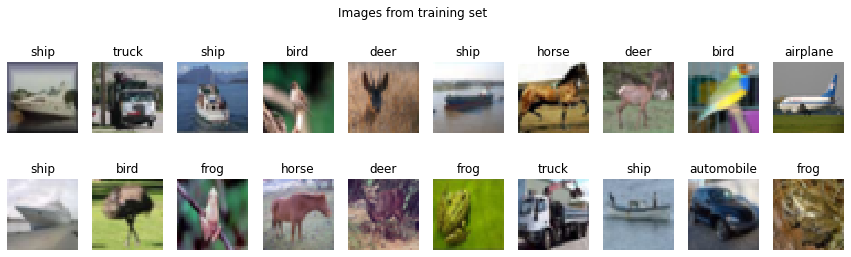

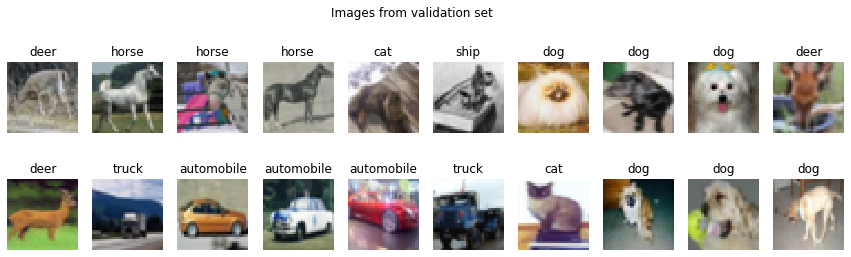

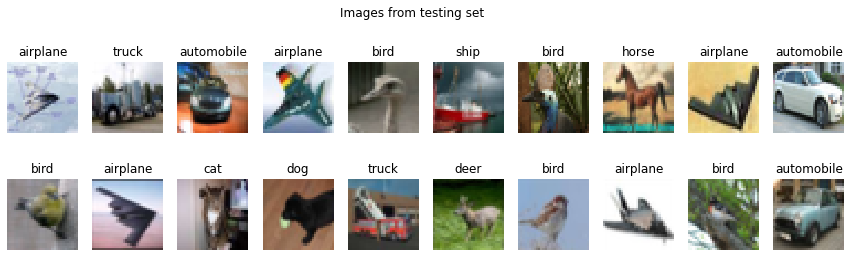

In [5]:
display_images(X_train, y_train, dataset="training")
display_images(X_val, y_val, dataset="validation")
display_images(X_test, y_test, dataset="testing")


### 3. Implementation of an MLP

The designed MLP model has 1 input layer, 2 `Dense` hidden layers, and 1 `Dense` output layer. 
 - The input layer is a `Flatten` layer whose role is to convert each input image into a 1d array, so the `input_shape` is set based on the dimensions of each input image (i.e. 32x32x3).
 - The number of neurons in each `Dense` hidden layer is set to 500. These hidden layers all use the ReLU activation function and a certain initialization method.
 -  The dropout regularization is applied before every Dense layer in order to deal with overfit issue.
 - The number of neurons in `Dense` output layer is set to 10 as there are 10 classes in the dataset. The output layer use softmax activation function because the classes are exclusive.

#### 3.1 Create a function that will build and compile a Keras model

The function below takes 3 input parameters `lr_schedule`, `init_mode`, `dropout_rate` and return with a built and compiled model. 

 - `lr_schedule` is learning rate scheduling. In this case we use either `exponetial scheduling` or `piecewise scheduling` for the SGD optimizer, which depends on the the result of grid search. In addition, we use `keras.optimizers.schedules` to define the learning rate scheduler in order to save the learning rate and its schedule (including its state) when save the model.
 - `init_mode` is the initalization method for hidden layers to initialize connection weights.
 - `dropout_rate` is the dropout rate that is used in the dropout regularization before every `Dense` layer in the model.

After the model is built and compiled, we use `KerasClassifier` to wrap around it for grid search as the model is designed for image classification.

In [6]:
# create a function that will build and compile a Keras model
def build_model(lr_schedule='exponetial',  init_mode='he_uniform', dropout_rate=0.2):
   model = keras.models.Sequential()

   # input layer
   model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))

   # hidden layers
   model.add(keras.layers.Dropout(dropout_rate))
   model.add(keras.layers.Dense(
       500, kernel_initializer=init_mode, activation="relu"))
   model.add(keras.layers.Dropout(dropout_rate))
   model.add(keras.layers.Dense(
       500, kernel_initializer=init_mode, activation="relu"))
   model.add(keras.layers.Dropout(dropout_rate))
   # output layer
   model.add(keras.layers.Dense(10, activation="softmax"))

   learning_rate = 0.001
   # exponetial decay scheduling
   if lr_schedule == 'exponetial':
      # number of steps in 20 epochs (batch size = 32)
      s = 20 * len(X_train) // 32
      learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
      

   # piecewise constant decay scheduling
   elif lr_schedule == 'piecewise':
      boundaries = [20 * len(X_train) // 32, 50 * len(X_train) // 32]
      values = [0.01, 0.005, 0.001]
      learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
          boundaries, values)

   optimizer = keras.optimizers.SGD(learning_rate)
   model.compile(loss="sparse_categorical_crossentropy",
               optimizer=optimizer,
               metrics=["accuracy"])

   return model

# create a KerasClassifier based on this build_model() function:
keras_cls = keras.wrappers.scikit_learn.KerasClassifier(build_model, batch_size=32)


#### 3.2 Fine-tuning hyperparameter

This section uses grid search with 3-fold cross-validation to find the optimal combination of values for: 
 - learning rate scheduler (exponetial or piecewise), which seek to adjust the learning rate during training by reducing the learning rate according to a pre-defined schedule.
 - init mode (he_normal or he_uniform), which determines the statistical distribution or function to use for initialising the weights.
 - and dropout rate (0.2 or 0.4), the rate of ignoring neurons randomly during training.


Applying early stopping to avoid overfit issue and halt the training at the proper time. we set `monitor='val_accuracy'` to seek a maximum for vaildation accuracy. we set `min_delta=0.01`, `patience=10`, and `restore_best_weights=True` to retore model weights from the epoch with the best value of the monitored quantity when there is no more than 0.01 improvement after training 10 epochs. 



```
earlyStop = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', mode='max', min_delta=0.01, restore_best_weights=True, patience=10)
grid_search_param = {
    "lr_schedule": ['exponetial', 'piecewise'],
    "init_mode": ['he_normal',  'he_uniform'],
    "dropout_rate" : [0.2, 0.4],
}
grid_search_cv = GridSearchCV(keras_cls, grid_search_param, cv=3)
grid_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_val, y_val),
                   callbacks=[earlyStop])
print(grid_search_cv.best_params_)
```
The optimal combination of values for these 3 hyperparameters:

`{'dropout_rate': 0.2, 'init_mode': 'he_uniform', 'lr_schedule': 'piecewise'}`

#### 3.3 Model training 

In [7]:
mlp_computation_time = 0
# if MLP model subdirectory is present in the current directory
if os.path.exists('Zhang_Wenxiao-MLP'):
    # load the model,
    mlp_model = keras.models.load_model('Zhang_Wenxiao-MLP')
    # display its architecture,
    print(mlp_model.summary())
    # train for one epoch.
    mlp_start = time.time()
    mlp_model.fit(X_train, y_train, epochs=1)
    mlp_end = time.time()
    # measure computation time
    mlp_computation_time = mlp_end - mlp_start
else:
    # set up the model and display its architecture,
    mlp_model = build_model(dropout_rate=0.2,
                            init_mode='he_uniform', lr_schedule='piecewise')
    print(mlp_model.summary())
    # train the model from scratch for 100 epochs using the optimal hyperparamter values
    earlyStop = keras.callbacks.EarlyStopping(
        monitor='val_accuracy', mode='max', min_delta=0.01, restore_best_weights=True, patience=10)
    mlp_model.fit(X_train, y_train, epochs=100,
                  validation_data=(X_val, y_val), callbacks=[earlyStop])
    os.makedirs('Zhang_Wenxiao-MLP')
    # save the model to the directory
    mlp_model.save('Zhang_Wenxiao-MLP')


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 500)               1536500   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5

In [8]:
# use the model to perform predictions on training set
mlp_pred_train = mlp_model.predict(X_train)
# use the model to perform predictions on testing set
mlp_pred = mlp_model.predict(X_test)

#### 3.4 Compare accuracies and F1 scores for both training and testing sets

In [9]:
mlp_pred_train_bool = np.argmax(mlp_pred_train, axis=1)
mlp_pred_bool = np.argmax(mlp_pred, axis=1)

mlp_train_acc = accuracy_score(y_train, mlp_pred_train_bool)
mlp_test_acc = accuracy_score(y_test, mlp_pred_bool)
mlp_train_f1 = f1_score(y_train, mlp_pred_train_bool, average="macro")
mlp_test_f1 = f1_score(y_test, mlp_pred_bool, average="macro")


print('MLP accuracy score on training set: {:,}'.format(mlp_train_acc))
print('MLP accuracy score on testing set: {:,}'.format(mlp_test_acc))
print('MLP F1 score on training set: {:,}'.format(mlp_train_f1))
print('MLP F1 score on testing set: {:,}'.format(mlp_test_f1))

MLP accuracy score on training set: 0.5093411764705882
MLP accuracy score on testing set: 0.4781
MLP F1 score on training set: 0.5050315843203571
MLP F1 score on testing set: 0.47251314068085337


#### 3.5 Compare confusion matrices for both training and testing sets

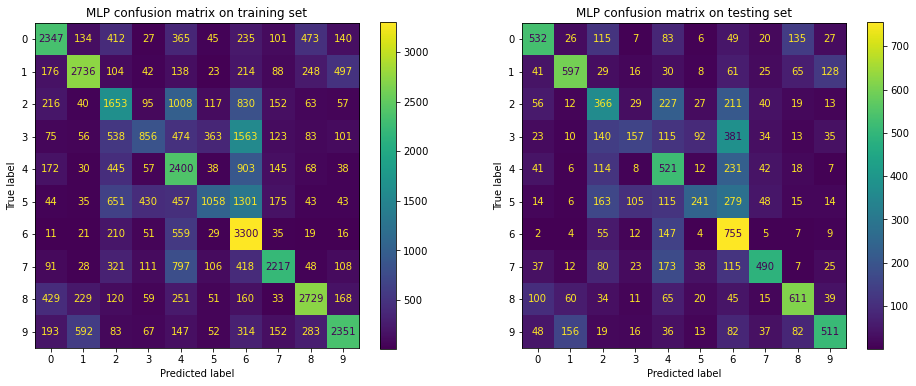

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

mlp_disp_train = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(
    y_train, mlp_pred_train_bool))
mlp_disp_train.plot(ax = ax[0])
ax[0].set_title('MLP confusion matrix on training set')

mlp_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(
    y_test, mlp_pred_bool))
mlp_disp.plot(ax=ax[1])
ax[1].set_title('MLP confusion matrix on testing set')

plt.show()

#### 3.6 Discussion
The accuracy score and F1 score on training set are all slightly higher than those on testing set and all of them are close to 0.5. As for the confusion matrices on both datasets, we can see that the value of true positive of each class label is all relatively higher than other values. From this two results we can see that MLP model can generally perform prediction on both dataset, though the accuracy is not very high.

### 4. Implementation of a CNN

The designed CNN model has 2 convolutional layers, 1 flatten layer, 2 dense hidden layers, 1 output layer. 
 - each convolutional layer followed by 1 batch normalization layer and 1 pooling layer. 
   - Batch normalization layer is used for addressing the vanishing/exploding gradients problems.
   - Pooling layer is used for limiting the risk of overfitting.
 - The flatten layer, hidden layer and output layer are using the same setting of the MLP model above.
 -  The learning rate scheduling, and the dropout value are set to the optimal value we got above.

#### 4.1 Create a function that will build and compile a Keras model

The function below takes 3 input parameters `kernel_size`, `filters`, `activation` and return with a built and compiled model. 

 - `kernel_size` is the size of the 2D convolution window.
 - `filters` is the number of output filters in the convolution.
 - `activation` is the activation function.

After the model is built and compiled, we also use `KerasClassifier` to wrap around it for grid search.

In [11]:
def build_model_cnn(kernel_size=(3,3), filters=32, activation="relu"):
    # create model
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(kernel_size=kernel_size, filters=filters,
            activation=activation, padding="same", input_shape=[32, 32, 3]))
    model.add(keras.layers.BatchNormalization()),
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Conv2D(kernel_size=kernel_size, filters=filters,
              activation=activation, padding="same", input_shape=[32, 32, 3]))
    model.add(keras.layers.BatchNormalization()),
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    # add MLP
    # input layer
    model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
   # hidden layers
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(
        500, kernel_initializer='he_uniform', activation=activation))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(
        500, kernel_initializer='he_uniform', activation=activation))
    model.add(keras.layers.Dropout(0.2))
    # output layer
    model.add(keras.layers.Dense(10, activation="softmax"))
    # piecewise constant decay scheduling
    boundaries = [20 * len(X_train) // 32, 50 * len(X_train) // 32]
    values = [0.01, 0.005, 0.001]
    learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries, values)
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])
    return model


# create a KerasClassifier based on this build_model_cnn() function:
keras_cls_cnn = keras.wrappers.scikit_learn.KerasClassifier(
    build_model_cnn, batch_size=32)


#### 4.2 Fine-tuning hyperparameter

Use grid search with 3-fold cross-validation to find the optimal combination of values for: 
 - kernel size ((3,3) or (5,5)), which justifies the 2d convolutional window.
 - filters (32 or 64), which is to justify the number of kernel.
 - and activation function (relu or selu). We use the same `earlyStop` strategy here.
```
earlyStop = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', mode='max', min_delta=0.01, restore_best_weights=True, patience=10)
grid_search_param_cnn = {
    "kernel_size": [(3,3), (5,5)],
    "filters": [64,  128],
    "activation": ['relu', 'selu'],
}
grid_search_cnn = GridSearchCV(keras_cls_cnn, grid_search_param_cnn, cv=3)
grid_search_cnn.fit(X_train, y_train, epochs=100,
                    validation_data=(X_val, y_val), callbacks=[earlyStop])

print(grid_search_cnn.best_params_)
```
The optimal combination of values for these 3 hyperparameters:

`{'activation': 'relu', 'filters': 128, 'kernel_size': (3, 3)}`

#### 4.3 Model training 

In [12]:
cnn_computation_time = 0
# if the CNN model subdirectory is present in the current directory
if os.path.exists('Zhang_Wenxiao-CNN'):
    # load the model,
    cnn_model = keras.models.load_model('Zhang_Wenxiao-CNN')
    # display its architecture,
    print(cnn_model.summary())
    # train for one epoch.
    cnn_start = time.time()
    cnn_model.fit(X_train, y_train, epochs=1)
    cnn_end = time.time()
    # measure computation time
    cnn_computation_time = cnn_end - cnn_start
else:
    # set up the model and display its architecture,
    cnn_model = build_model_cnn(kernel_size=(3, 3), filters=128, activation="relu")
    print(cnn_model.summary())
    # train the model from scratch for 100 epochs using the optimal hyperparamter values.
    earlyStop = keras.callbacks.EarlyStopping(
        monitor='val_accuracy', mode='max', min_delta=0.01, restore_best_weights=True, patience=10)
    cnn_model.fit(X_train, y_train, epochs=100,
                  validation_data=(X_val, y_val), callbacks=[earlyStop])
    # save the model to the directory
    os.makedirs('Zhang_Wenxiao-CNN')
    cnn_model.save('Zhang_Wenxiao-CNN')


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

In [13]:
# use the model to perform predictions on training test.
cnn_pred_train = cnn_model.predict(X_train)
# use the model to perform predictions on testing test.
cnn_pred = cnn_model.predict(X_test)

#### 4.4 Compare accuracies and F1 scores for both training and testing sets

In [14]:
cnn_pred_train_bool = np.argmax(cnn_pred_train, axis=1)
cnn_pred_bool = np.argmax(cnn_pred, axis=1)
cnn_train_acc = accuracy_score(y_train, cnn_pred_train_bool)
cnn_test_acc = accuracy_score(y_test, cnn_pred_bool)
cnn_train_f1 = f1_score(y_train, cnn_pred_train_bool, average="macro")
cnn_test_f1 = f1_score(y_test, cnn_pred_bool, average="macro")

print('CNN accuracy score on training set: {:,}'.format(cnn_train_acc))
print('CNN accuracy score on testing set: {:,}'.format(cnn_test_acc))
print('CNN F1 score on training set: {:,}'.format(cnn_train_f1))
print('CNN F1 score on testing set: {:,}'.format(cnn_test_f1))


CNN accuracy score on training set: 0.9832235294117647
CNN accuracy score on testing set: 0.7344
CNN F1 score on training set: 0.9832206312239483
CNN F1 score on testing set: 0.7348981496955207


#### 4.5 Compare confusion matrices for both training and testing sets

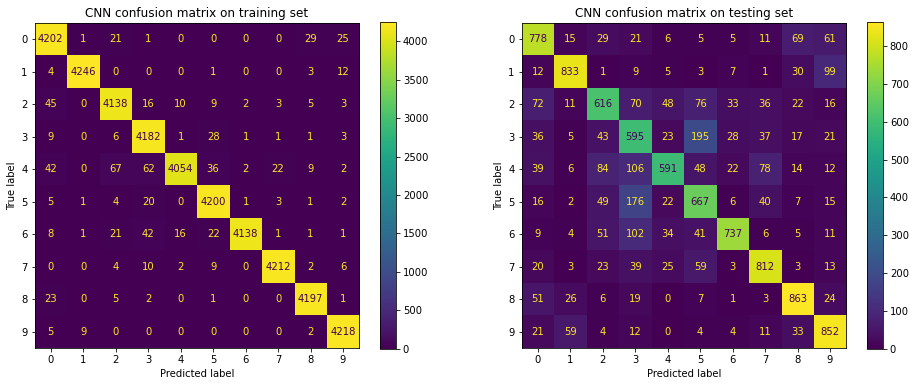

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

cnn_disp_train = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(
    y_train, cnn_pred_train_bool))
cnn_disp_train.plot(ax=ax[0])
ax[0].set_title('CNN confusion matrix on training set')

cnn_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(
    y_test, cnn_pred_bool))
cnn_disp.plot(ax=ax[1])
ax[1].set_title('CNN confusion matrix on testing set')

plt.show()


#### 4.6 Discussion

The accuracy score and F1 score on training set are very high, nearly reached 1, while on testing set, both of them are around 0.7, which is also very well-performed. As for the confusion matrices for both datasets, the value of true positive for each class label is all very high, which also suggests the good performance of the CNN model.

### 5. Compare MLP and CNN models on the test set

#### 5.1 Compare the classification performance

In [16]:
# MLP
print(classification_report(y_test, mlp_pred_bool))

              precision    recall  f1-score   support

           0       0.60      0.53      0.56      1000
           1       0.67      0.60      0.63      1000
           2       0.33      0.37      0.35      1000
           3       0.41      0.16      0.23      1000
           4       0.34      0.52      0.41      1000
           5       0.52      0.24      0.33      1000
           6       0.34      0.76      0.47      1000
           7       0.65      0.49      0.56      1000
           8       0.63      0.61      0.62      1000
           9       0.63      0.51      0.57      1000

    accuracy                           0.48     10000
   macro avg       0.51      0.48      0.47     10000
weighted avg       0.51      0.48      0.47     10000



In [17]:
# CNN
print(classification_report(y_test, cnn_pred_bool))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76      1000
           1       0.86      0.83      0.85      1000
           2       0.68      0.62      0.65      1000
           3       0.52      0.59      0.55      1000
           4       0.78      0.59      0.67      1000
           5       0.60      0.67      0.63      1000
           6       0.87      0.74      0.80      1000
           7       0.78      0.81      0.80      1000
           8       0.81      0.86      0.84      1000
           9       0.76      0.85      0.80      1000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.73      0.73     10000



#### 5.2 Compare confusion matrices

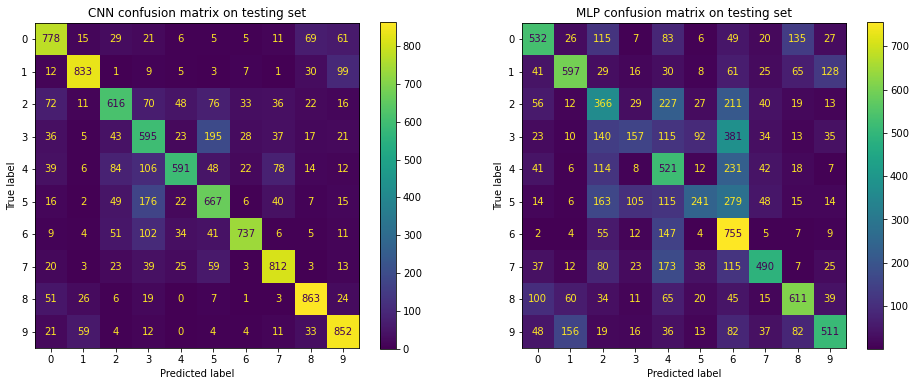

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))


cnn_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(
    y_test, cnn_pred_bool))
cnn_disp.plot(ax=ax[0])
ax[0].set_title('CNN confusion matrix on testing set')

mlp_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(
    y_test, mlp_pred_bool))
mlp_disp.plot(ax=ax[1])
ax[1].set_title('MLP confusion matrix on testing set')

plt.show()


#### 5.3 Compare model complexity

In [19]:
mlp_trainable_count = int(np.sum([K.count_params(w) for w in mlp_model.trainable_weights]))
cnn_trainable_count = int(np.sum([K.count_params(w) for w in cnn_model.trainable_weights]))

print('MLP Trainable params: {:,}'.format(mlp_trainable_count))
print('CNN Trainable params: {:,}'.format(cnn_trainable_count))


MLP Trainable params: 1,792,010
CNN Trainable params: 4,503,690


#### 5.4 Compare computation time

In [20]:
print('MLP computation time for 1 training epoch: {:,}'.format(mlp_computation_time))
print('CNN computation time for 1 training epoch: {:,}'.format(cnn_computation_time))

MLP computation time for 1 training epoch: 4.906998157501221
CNN computation time for 1 training epoch: 10.087132215499878


#### 5.5 Discussion

 - From the classification report we can see that the classification performance of CNN is overall higher than that of MLP. In particular, the precision, recall, f1 score, and accuracy score of CNN are all higher than those of MLP.

 - From the comparsion of confusion matrices we can see that CNN has more true postive values than MLP for each class label, which means CNN has a better performance.

 - From the perspective of model complexity we can see that CNN has more trainable params that MLP, which means CNN is more complex than MLP.

 - From the computation time we can see that CNN takes approximately 5 seconds longer than MLP for 1 training epoch.

 - From these evidence above, we can see that a more complex model (i.e. CNN) may have a better performance, but may take longer computation time for training.

#### 5.6 Compare classified images

We compare the classified results on four groups of images, specifically, 
 - group 1: Five images correctly classified by MLP while incorrectly classified by CNN
 - group 2: Five images incorrectly classified by MLP while correctly classified by CNN
 - group 3: Five images that both MLP and CNN classified incorrectly
 - group 4: Five images that both MLP and CNN classified correctly

Each image has a title that contains the image label classified by MLP, the image label classified by CNN, and the real image label recorded in the test set.

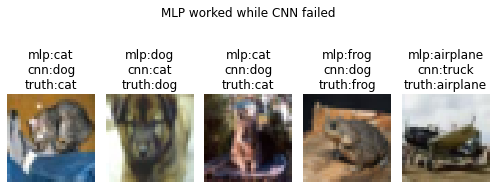

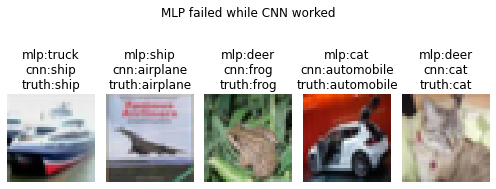

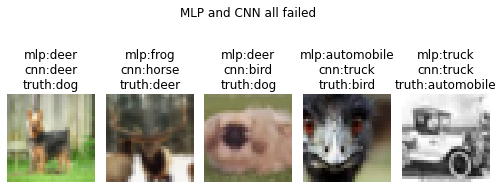

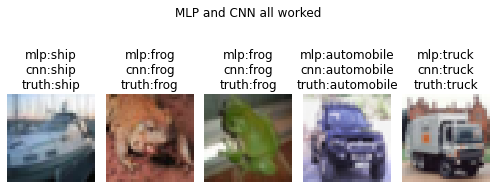

In [21]:
# Images correctly classified by MLP while incorrectly classified by CNN
index1 = 0
index2 = 0
index3 = 0
index4 = 0
fig1, axes1 = plt.subplots(1, 5, figsize=(7, 5))
fig2, axes2 = plt.subplots(1, 5, figsize=(7, 5))
fig3, axes3 = plt.subplots(1, 5, figsize=(7, 5))
fig4, axes4 = plt.subplots(1, 5, figsize=(7, 5))
fig1.suptitle("MLP worked while CNN failed")
fig2.suptitle("MLP failed while CNN worked")
fig3.suptitle("MLP and CNN all failed")
fig4.suptitle("MLP and CNN all worked")
for i in range(len(mlp_pred_bool)):
    # mlp worked while cnn failed
    if y_test[i] == mlp_pred_bool[i] and y_test[i] != cnn_pred_bool[i] and index1 < 5:
        axes1[index1].plot()
        axes1[index1].imshow(X_test[i], cmap="binary",
                                    interpolation="nearest")
        axes1[index1].axis('off')
        axes1[index1].set_title(
            'mlp:'+class_names[mlp_pred_bool[i]] + '\ncnn:'+class_names[cnn_pred_bool[i]] + '\ntruth:'+class_names[y_test[i]], fontsize=12)
        index1 += 1
    
    # mlp failed while cnn worked
    elif y_test[i] != mlp_pred_bool[i] and y_test[i] == cnn_pred_bool[i] and index2 < 5:
        axes2[index2].plot()
        axes2[index2].imshow(X_test[i], cmap="binary",
                             interpolation="nearest")
        axes2[index2].axis('off')
        axes2[index2].set_title(
            'mlp:'+class_names[mlp_pred_bool[i]] + '\ncnn:'+class_names[cnn_pred_bool[i]] + '\ntruth:'+class_names[y_test[i]], fontsize=12)
        index2 += 1
    
    # mlp and cnn all failed
    elif y_test[i] != mlp_pred_bool[i] and y_test[i] != cnn_pred_bool[i] and index3 < 5:
        axes3[index3].plot()
        axes3[index3].imshow(X_test[i], cmap="binary",
                             interpolation="nearest")
        axes3[index3].axis('off')
        axes3[index3].set_title(
            'mlp:'+class_names[mlp_pred_bool[i]] + '\ncnn:'+class_names[cnn_pred_bool[i]] + '\ntruth:'+class_names[y_test[i]], fontsize=12)
        index3 += 1
    
    # mlp and cnn all worked
    elif y_test[i] == mlp_pred_bool[i] and y_test[i] == cnn_pred_bool[i] and index4 < 5:
        axes4[index4].plot()
        axes4[index4].imshow(X_test[i], cmap="binary",
                             interpolation="nearest")
        axes4[index4].axis('off')
        axes4[index4].set_title(
            'mlp:'+class_names[mlp_pred_bool[i]] + '\ncnn:'+class_names[cnn_pred_bool[i]] + '\ntruth:'+class_names[y_test[i]], fontsize=12)
        index4 += 1
    
    if index1==5 and index2==5 and index3==5 and index4==5:
        break

fig1.tight_layout()
fig1.subplots_adjust(top=1.2)

fig2.tight_layout()
fig2.subplots_adjust(top=1.2)

fig2.tight_layout()
fig2.subplots_adjust(top=1.2)

fig3.tight_layout()
fig3.subplots_adjust(top=1.2)

fig4.tight_layout()
fig4.subplots_adjust(top=1.2)

plt.show()


#### 5.7 Discussion

In the case of MLP and CNN all failed, we can see that MLP and CNN has similar prediction values on the same images, which means those images may be very ambiguous that can easily get wrong with another class. For example, in the third group, the first image `dog` is classified into `deer` by both models, which means these two classes may have similar image features.